# Homework 3

In this homework, you will learn about hyper-parameters and use hold-out validation sets and cross-validation to select a trained model among several. You will also apply the algorithms we learned to a real-world dataset.

There are a number of programming **tasks** and **quiz questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **quiz questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

-----

## Preparation

In [5]:
from typing import Dict, List, Optional, Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
import utils
from scipy import stats

In [6]:
seed = 0
np.random.seed(seed)

In [7]:
from utils import TrainAndTestData

LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

train_test_ratio = 0.8
Xsp_train, ysp_train, Xsp_test, ysp_test = utils.create_split(Xsp, ysp, train_test_ratio)
spirals = TrainAndTestData(Xsp_train, ysp_train, Xsp_test, ysp_test)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

## Validation for Machine Learning Models

### [Task 1] Model selection: use a validation set to determine $k$ in $k$-Nearest Neighbor predictors

In HW1 and HW2, we tried both 1-NN and $k$-NN predictors. However, it is impossible to know which $k$ without trying out different values of $k$ and evaluating on the test set, but **we can only use the test set once**!

$k$ here is a **hyperparameter** of Nearest Neighbor predictor. Hyperparameters are parameters of a Machine Learning model that the model does not learn from the training set, but that is specified and _tuned_ by the user. Since there are a large number of $k$-Nearest Neighbor predictors for a given training set (each specified by the hyperparameter $k \in \mathbb{N}$), how would you select which one to ship in practice?

To select the model that would generalize best, it is common practice to carve out a validation set _from_ the training set. We can then fit a learning rule with different hyperparameters on the leftover training set (which we will now also call the training set as before) and compare the trained learning rules, i.e. predictors, by evaluating them on the validation set.

Why are we doing all this? Recall again that we only want to use the test set _once_. Once we have evaluated a fitted predictor on the test set, we should **not** be changing the hyperparameters of the predictor, retraining, and evaluating on the test set repeatedly. This defeats the purpose of the "secretive" test set. Therefore, we will use the validation set to improve our predictor, which is allowed since these points were originally given to us for training.

In this task, create a validation set out of your training set for the spiral data. Train $k$-Nearest Neighbor predictors using the `scikit-learn` library for **a large range** of $k$ and plot the training error and validation error as a function of $k$. Use the plot to fix the hyperparameter $k$ (call it `best_k`), train on the full training set, and report **both** the training and test errors. Feel free to add additional plots, such as a predictor's decision boundary.

A few things you should thing about:
- The range of values you explore for $k$ is up to you. If the range is too large, make sure you use a fine enough grid for the Error v $k$ plot (e.g. a linear or a [logarithmic](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogx.html) x-axis).
- The size of the validation set.
- Think about what you should use to select the best model.
- Make sure you label the axes of the error plot!
- Make sure your plot is readable and conveys the information you want without confusing the reader. Use what works best: adding axes labels and legends, adjusting the scale of axis (linear/logarithmic), and so on.

k: 3 is best, train_err: 7.78%, val_err: 16.25%


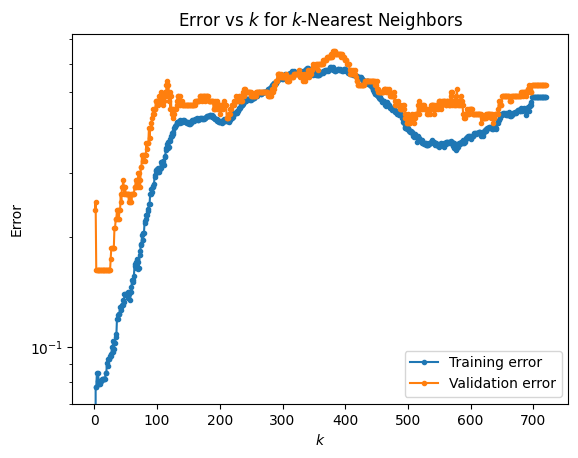

In [5]:
# Find the best k in this code cell
# best_k = 1
# train_err_best_k = 0.
# val_err_best_k = 0.
from sklearn.neighbors import KNeighborsClassifier
from utils import empirical_err
# Create Train val split
train_val_ratio = 0.9
Xsp_train_new, ysp_train_new, Xsp_val, ysp_val = utils.create_split(spirals.X_train, spirals.y_train, train_val_ratio)

ks = [i for i in range(1, len(Xsp_train_new)+1)]
train_errs = []
val_errs = []
#### TASK 1 CODE
for k_val in ks:
    knn_clf = KNeighborsClassifier(n_neighbors=k_val)
    knn_clf.fit(Xsp_train_new, ysp_train_new)
    train_errs.append(empirical_err(knn_clf,Xsp_train_new,ysp_train_new))
    val_errs.append(empirical_err(knn_clf, Xsp_val, ysp_val))
#### TASK 1 CODE

plt.figure()
plt.semilogy(ks, train_errs, label='Training error', marker='.')
plt.semilogy(ks, val_errs, label='Validation error', marker='.')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('Error')
plt.title('Error vs $k$ for $k$-Nearest Neighbors')

best_k = ks[np.argmin(val_errs)]

train_err_best_k = train_errs[ks.index(best_k)]
val_err_best_k = val_errs[ks.index(best_k)]
print(f'k: {best_k} is best, train_err: {train_err_best_k*100:0.2f}%, val_err: {val_err_best_k*100:0.2f}%')

k: 3
Train error: 8.25%
Test error: 8.50%


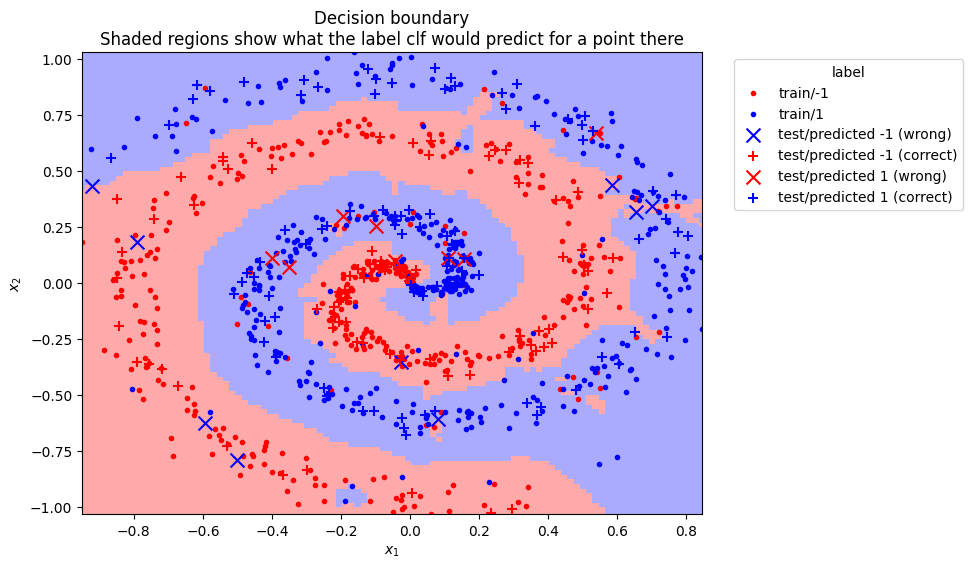

In [6]:
# Train a kNN on the full training set with the best k in this code cell

knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(Xsp_train, ysp_train)

# Get training and testing errors
print(f'k: {best_k}')
spirals.print_errors(knn_clf)

utils.plot_decision_boundary(knn_clf, spirals.X_train, spirals.y_train, spirals.X_test, spirals.y_test)

### $k$-fold cross-validation

If you select a really small validation set, the validation error will not be a good estimate of the expected error of a predictor (learning rule with a hyperparameter setting trained on a set of points). Therefore, it will be difficult to determine which hyperparameter setting yields a good predictor. We could make the validation set larger to get a better estimate of the expected error, but at the expense of reducing the number of training points (which hurts training a learning rule in the first place!).

One way to overcome the scarcity of total training points is by using $k$-fold Cross Validation to select hyperparameters. It divides the training set into $k$ partitions (folds). For each set or fold $S_i$, we train a learning rule on the union of the other $k-1$ folds and evaluate on $S_i$, thus performing $k$ validations. Finally we take the average of the $k$ validation errors, getting a much better estimate of the true error than if we had used a single hold-out validation set. Informally, we use all of the available training points for validation by excluding them in folds, training on the leftover data to get predictors, and evaluating the predictors on the folds. Note that if $k = m$ where $m$ is the number of training samples, $k$-fold Cross Validation is the same as Leave-One-Out Cross Validation (you saw $\textrm{LOOCV}$ in Problem 4 of the written part of Homework 2).

See also Section 11.2.4 of [UML] for a discussion on $k$-fold Cross Validation.


### [Task 2] $k$-fold cross-validation for a `n_neighbor`-Nearest Neighbor predictor
In this task, implement $k$-fold Cross Validation to determine the best number of neighbors `n_neighbors` on spiral data. We are using `n_neighbors` for Nearest Neighbors to avoid overloading the $k$ in Nearest Neighbors and Cross Validation. The choice of $k$, the number of folds, is up to you. Plot the $k$-fold Cross Validation error (average validation error) against `n_neighbors`. Finally, select the best `n_neighbors` (think about how you would compare Nearest Neighbor predictors of different `n_neighbors`), train a `best_n_neighbors`-Nearest Neighbor predictor using the full training set and calculate **both** the training and test errors.

For convenience, here are the subtasks written explicitly:
- Implement the `kfoldCV_err` function that returns the $k$-fold Cross Validation error (average validation error across folds). This function takes in data points (to partition, train, and evaluate), number of folds `kfolds`, the implementation of the learning rule in `clf_class` (your choice between `KNeighborsClassifier` and `KNeighborsScratch` implementations in this task) and the hyperparameter settings to instantiate a predictor in `**clf_kwargs`.
- For some range of `n_neighbors` values, find $k$-fold Cross Validation error for each of them and plot the errors against `n_neighbors`.
- Pick the best `n_neighbors` (think how to select the best one), train a predictor on the _full_ training set, and calculate **both** training and test errors.

**DO NOT use `scikit-learn`'s implementation of $k$-fold Cross Validation. You should implement from scratch.**

In [7]:
# Implement kfoldCV_err in this code cell
import math
def kfoldCV_err(
    X: np.ndarray,
    y: np.ndarray,
    kfolds: int,
    clf_class,
    **clf_kwargs
) -> float:
    '''
    Returns the kfold Cross Validation error of learning rule clf_class fit
    using hyperparameters specified as keyword args in this function.

    At least kfolds-1 of the folds are equal in size. The last fold can be smaller if m,
    the number of training points, is not a integer multiple of kfolds.

    `clf_class` learning rule can be instantiated with keyword arguments
    `**clf_kwargs` as `clf_class(**clf_kwargs)`.
    Reference for `**kwargs` notation in Python: https://www.geeksforgeeks.org/args-kwargs-python/

    For 3-Nearest Neighbor predictor, use as:
        ```
        err = kfoldCV_err(X, y, kfolds, KNeighborsClassifier, n_neighbors=3)
        ```

    Args:
        X: data features
        y: data labels
        kfolds: number of folds of X for kfold CV (must be at most number of points in X)
        clf_class: class with fit() and predict() methods to instantiate a predictor
        **clf_kwargs: keyword arguments passed to clf_class

    Returns:
        err: The kfold Cross Validation error
    '''
    assert X.shape[0] == len(y)
    assert kfolds <= X.shape[0]

    #### TASK 2 CODE
    err = 0.
    m = X.shape[0]
    fold_size = math.ceil(m/kfolds)
    for i in range(kfolds):
        clf = clf_class(**clf_kwargs)
        idx = np.arange(X.shape[0])
        train_idx = (idx < fold_size * i) + (idx >= fold_size * (i+1))
        val_idx = (idx >= fold_size * i) * (idx < fold_size * (i+1))
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_val = X[val_idx]
        y_val = y[val_idx]
        clf.fit(X_train, y_train)
        err += empirical_err(clf, X_val, y_val)
    
    err /= kfolds
    #### TASK 2 CODE

    return err

n_neighbors: 7 is best, val_err: 8.88%


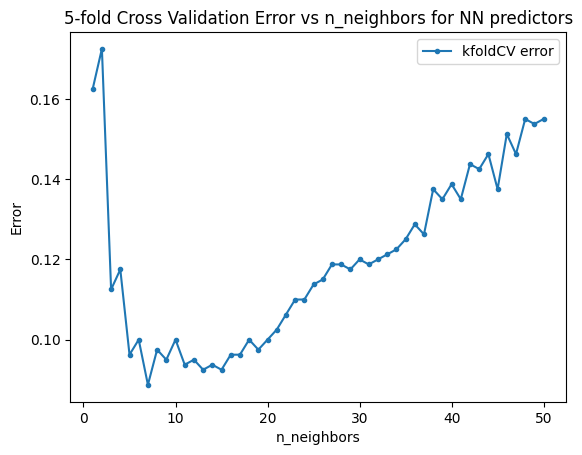

In [8]:
# Find the best n_neighbors in this code cell

# best_n_neighbors = 1
# val_err_best_n_neighbors = 0.

kfolds = 5

# Train for different n_neighbors
ns = [i for i in range(1, 51)]
val_errs = np.zeros((len(ns)))

for i, n in enumerate(ns):
    val_errs[i] = kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, KNeighborsClassifier, n_neighbors=n)

plt.figure()
plt.plot(ns, val_errs, label=f'kfoldCV error', marker='.')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Error')
plt.title(f'{kfolds}-fold Cross Validation Error vs n_neighbors for NN predictors')

best_n_neighbors = ns[np.argmin(val_errs)]
val_err_best_n_neighbors = val_errs[ns.index(best_n_neighbors)]

print(f'n_neighbors: {best_n_neighbors} is best, val_err: {val_err_best_n_neighbors*100:0.2f}%')

best_neighbors: 7
Train error: 8.75%
Test error: 6.50%


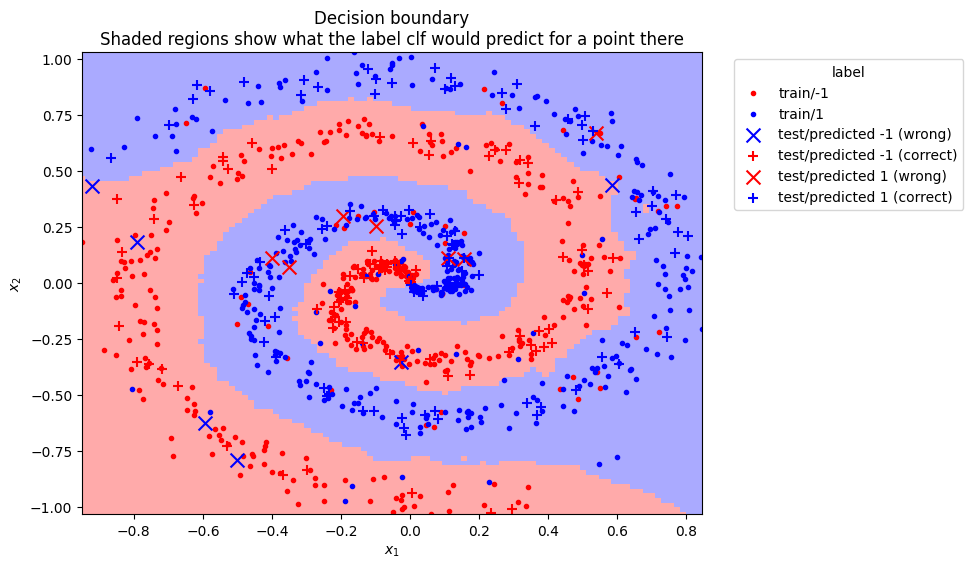

In [9]:
# Train a Nearest Neighbors predictor with the best n_neighbors in this code cell
kv_knn_clf = KNeighborsClassifier(n_neighbors=best_n_neighbors)
kv_knn_clf.fit(spirals.X_train, spirals.y_train)

# Get training and testing errors
print(f'best_neighbors: {best_n_neighbors}')
spirals.print_errors(kv_knn_clf)

utils.plot_decision_boundary(kv_knn_clf, spirals.X_train, spirals.y_train, spirals.X_test, spirals.y_test)

### [Task 3 (Optional)] Calculate the LOOCV error of a $k$-Nearest Neighbor predictor

In this **optional** task, complete the `LOOCV` method of `KNeighborsLOOCV`, which derives the functions and attributes of `KNeighborsClassifier`. We will then use your implementation of `LOOCV` method to calculate the $\textrm{LOOCV}$ error for a 3-Nearest Neighbor predictor on spiral data.

Recall from Problem 4 of Homework 2 that $\textrm{LOOCV}$ error on a set $S = \left\{ \left( x_i, y_i \right) \right\}_{i=1}^{m}$ for a learning rule $\mathcal{F}$ is defined as:

$$
\textrm{LOOCV}_S (\mathcal{F}) = \frac{\left| \left\{ i~\middle|~\mathcal{F}\left( S_{-i} \right) \left( x_i \right) \neq y_i \right\} \right|}{m}.
$$

Try to avoid loops, using only matrix operations to keep the implementation efficient. The most efficient implementation will not increase the runtime or memory complexity of training and predicting with a $k$-Nearest Neighbor predictor.

**With many learning rules, it is possible to obtain the LOOCV error at no additional cost! That is, we can be clever with our implementation and need not train $m$ times.**

Hint: the `LOOCV` method can be implemented by slightly modifying the `kNearestNeighbors.predict` method in HW2.

In [10]:
from scipy import stats

class KNeighborsLOOCV(KNeighborsClassifier):

    def __init__(self, n_neighbors: int):
        super().__init__(n_neighbors)
        self.X_train = None
        self.y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        '''
        Trains a k-Nearest Neighbor predictor with n_neighbors neighbors on training data (X, y).

        Args:
            X: data features
            y: data labels
        '''
        super().fit(X, y)
        # Save the training points; to be used during prediction
        self.X_train = X
        self.y_train = y

    def LOOCV(self) -> float:
        '''
        Returns the LOOCV error on the training set for k-Nearest Neighbor.
        '''
        assert (self.X_train is not None) and (self.y_train is not None), 'kNN not trained!'
        loocv = 0.

        #### TASK 3 CODE (optional)
        #### TASK 3 CODE (optional)

        return loocv

In [11]:
# LOOCV error of 3-Nearest Neighbor predictor on spiral data

clf = KNeighborsLOOCV(n_neighbors=3)
clf.fit(spirals.X_train, spirals.y_train)
loocv = clf.LOOCV()

print(f'LOOCV error of 3-NN: {loocv*100:0.2f}%')

LOOCV error of 3-NN: 0.00%


### [Task 4] Finding the best depth hyperparameter for decision trees based on validation set performance

In task 9 of HW2, we find that setting the depth hyperparameter larger and larger would lead to a decision tree with lower training error. In fact, as $d \rightarrow \infty$, the decision tree makes finer splits to label training data correctly. In the limit when we train a decision tree with unrestricted depth (`max_depth=None`), we can label all training data correctly. However, since our goal is to train a classifier that _generalizes_ well rather than to train one that gets zero training error, allowing unrestricted depth will fail us. We will therefore find the best hyperparameter `max_depth` for Decision Trees using a validation set as an estimate of true error of predictors.

In this task, you will find the best value of `max_depth` using a hold-out validation set carved out from the training set. We will use a large validation set and a smaller training set in this task. To be clear, if you had originally split the 1000 original spiral data points into a training set of 800 and test set of 200, you can carve out a 70% validation set from 800 training points and so just use 240 points for training.

Plot the empirical errors (training and validation) against `max_depth`.

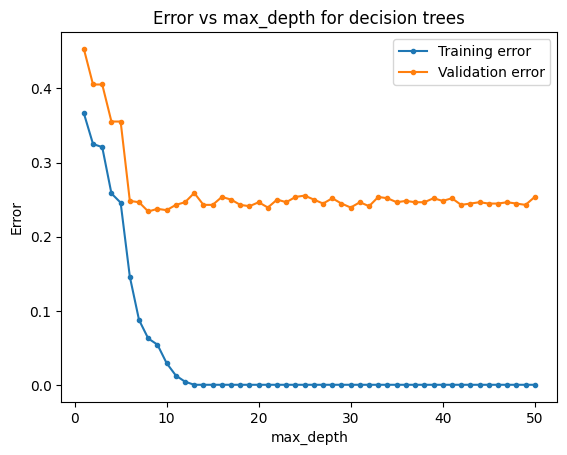

max_depth: 8 is best, val_err: 23.39%, test_err: 12.00%


In [12]:
from sklearn.tree import DecisionTreeClassifier

# Find best max_depth
# best_max_depth = 1
# val_err_best_max_depth = 0.

# Train for different max_depth
ds = [i for i in range(1, 51)]

Xsp_train_new, ysp_train_new, Xsp_val, ysp_val = utils.create_split(spirals.X_train, spirals.y_train, 0.3)

#### TASK 4 CODE
train_errs = []
val_errs = []
for d in ds:
    dt_clf = DecisionTreeClassifier(max_depth=d)
    dt_clf.fit(Xsp_train_new, ysp_train_new)
    train_errs.append(empirical_err(dt_clf, Xsp_train_new, ysp_train_new))
    val_errs.append(empirical_err(dt_clf, Xsp_val, ysp_val))
#### TASK 4 CODE

plt.figure()
plt.plot(ds, train_errs, label='Training error', marker='.')
plt.plot(ds, val_errs, label='Validation error', marker='.')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.title(f'Error vs max_depth for decision trees')
plt.show()

best_max_depth = ds[np.argmin(val_errs)]
val_err_best_max_depth = val_errs[ds.index(best_max_depth)]

dt_clf = DecisionTreeClassifier(max_depth=best_max_depth)
dt_clf.fit(spirals.X_train, spirals.y_train)
test_err_best_max_depth = utils.empirical_err(dt_clf, spirals.X_test, spirals.y_test)
print(f'max_depth: {best_max_depth} is best, val_err: {val_err_best_max_depth*100:0.2f}%, test_err: {test_err_best_max_depth*100:0.2f}%')


### Hyperparameters for Decision Tree

In practice, we might not have such generous access to the true distribution. Instead, we use $k$-fold Cross Validation to estimate the expected true error of different learning rules, e.g. a decision tree based on different values of `max_depth` and even different hyperparameters, such as impurity metrics (Gini Index, entropy etc.), maximum number of nodes, maximum number of leaf nodes, and so on. `scikit-learn`'s [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) implements many of such hyperparameters. Convince yourself that limiting only one of these hyperparameters at a time will yield different decision trees, and thus different learning rules.

<span style="color: red">
<h4 style="font-weight: bold">[Answer Questions]</h4>

In task 4, we select the predictor with the lowest validation error and evalute its performance on the same test set. In this context, is the test error for that predictor an unbiased estimator of its generalization error? This task closely resembles Task 9 in HW2. If you have different answers (regarding whether the test error serves as an unbiased estimator of the generalization error) in HW2 and HW3, could you explain why you consider the two cases to be different? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: For the same reason, the test error for the predictor is not an unbiased estimator of the generalization error.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### Pruning Decision Trees

Pruning is essential in decision trees. Since full-depth decision trees overfit to the training set, we can fit a full-depth decision tree and remove leaf nodes that do not reduce the impurity significantly in a bottom-up fashion. Even in a limited-depth tree or in a tree where the complexity is controlled by another hyperparameter such as `max_leaf_nodes`, pruning can be helpful in removing nodes that do not contribute significantly.

In `scikit-learn`, the [Minimal Cost-Complexity Pruning algorithm](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) is used with a hyperparameter $\alpha$, specified by `ccp_alpha` in `DecisionTreeClassifier`. As we increase $\alpha$, we prune off more and more nodes. In the Minimal Cost-Complexity Pruning algorithm, the leaf nodes with the least "effective" $\alpha$ are removed, creating a "pruning path". This path can be calculating using `scikit-learn`'s `cost_complexity_pruning_path` [function](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path). These effective $\alpha$ are then good candidates for the _best_ $\alpha$ as the pruning hyperparameter.

You can also read the [tutorial on pruning path](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) in `scikit-learn` documentation. See Section 18.2.2 of [UML] for a generic pruning algorithm.

**In practice, there is NO REASON NOT TO PRUNE. Pruning almost always reduces overfitting in a decision tree**.

Number of nodes in the last tree is: 1 with ccp_alpha: 0.050


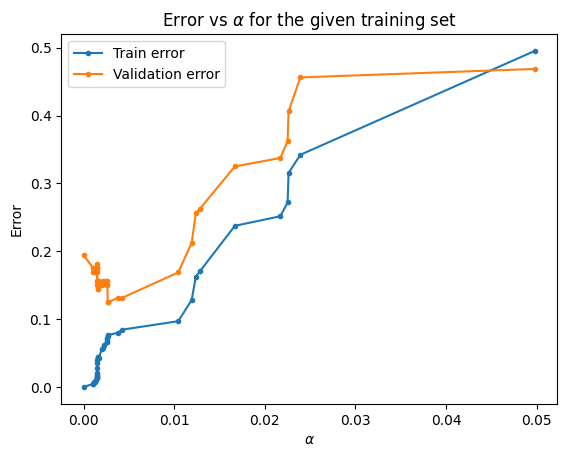

In [13]:
Xsp_train_new, ysp_train_new, Xsp_val, ysp_val = utils.create_split(Xsp_train, ysp_train, 0.8)

dt_prune_clf = DecisionTreeClassifier()
path = dt_prune_clf.cost_complexity_pruning_path(Xsp_train_new, ysp_train_new)
ccp_alphas = path.ccp_alphas

dt_prune_clfs = []
for ccp_alpha in ccp_alphas:
    dt_prune_clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dt_prune_clf.fit(Xsp_train_new, ysp_train_new)
    dt_prune_clfs.append(dt_prune_clf)
print(f'Number of nodes in the last tree is: {dt_prune_clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]:0.3f}')

train_errs = [utils.empirical_err(clf, Xsp_train_new, ysp_train_new) for clf in dt_prune_clfs]
val_errs = [utils.empirical_err(clf, Xsp_val, ysp_val) for clf in dt_prune_clfs]

plt.plot(ccp_alphas, train_errs, marker='.', label='Train error')
plt.plot(ccp_alphas, val_errs, marker='.', label='Validation error')
plt.xlabel('$\\alpha$')
plt.ylabel('Error')
plt.title('Error vs $\\alpha$ for the given training set')
plt.legend()
plt.show()

### [Task 5] Find best hyperparameter for decision trees

In this task, you will use $k$-fold Cross Validation to find the best hyperparameter for decision trees, among different values of `max_depth`, `max_leaf_nodes`, and `ccp_alpha`. That is, you should cross-validate decision trees specified by different hyperparameters, fitting each decision tree with one hyperparameter at a time without setting any other hyperparameters (so you get predictors for different hyperparameters and different hyperparameter values).

Plot the Cross Validation error as a function of `max_depth`, `max_leaf_nodes`, and `ccp_alpha` (so 3 plots). Select the best hyperparameter setting across all settings, train a decision tree on the full training set, and calculate **both** the training error and test error. Also plot the predictor's decision boundary.

max_depth: 9 is best, val_err: 16.00%
max_leaf_nodes: 25 is best, val_err: 13.50%
ccp_alpha: 0.004 is best, val_err: 14.00%
Train error: 9.25%
Test error: 11.00%


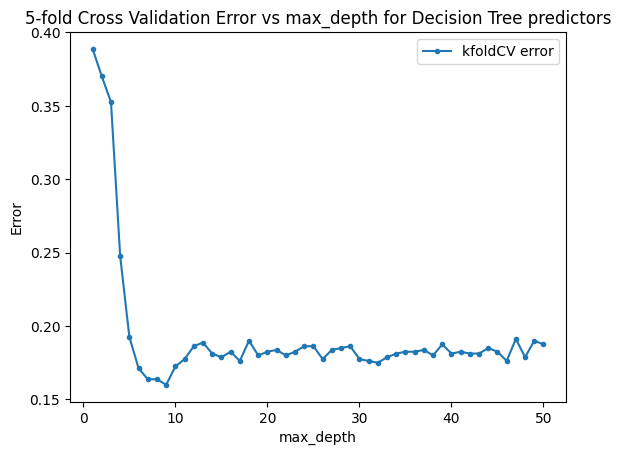

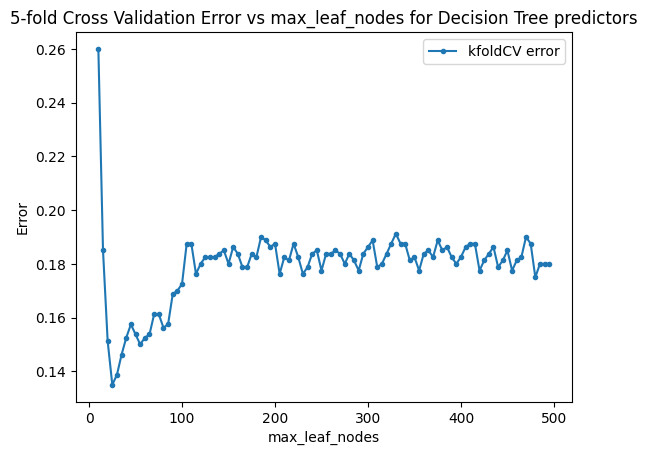

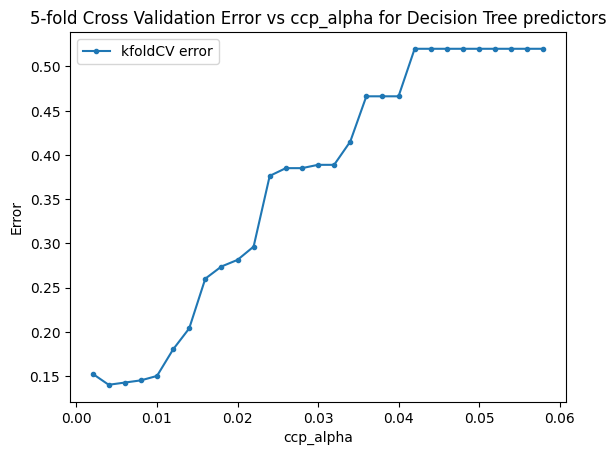

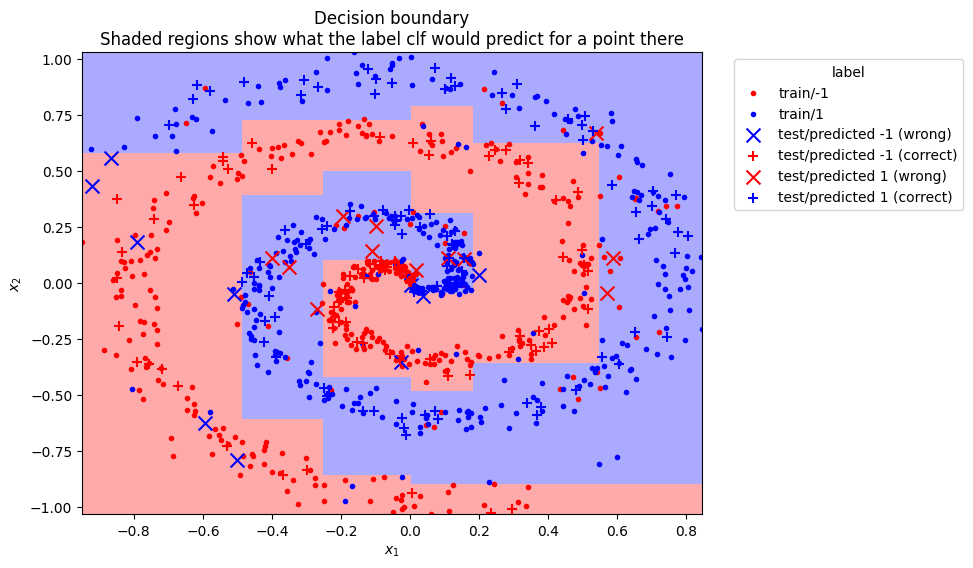

In [14]:
#### TASK 5 CODE
kfolds = 5

max_ds = np.arange(1, 51)
max_ls = np.arange(10, 500, 5)
ccp_alphas = np.arange(0.002, 0.06, 0.002)

# TUNING max_depth
val_errs_d = []
for d in max_ds:
    val_errs_d.append(kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, DecisionTreeClassifier, max_depth=d))

plt.figure()
plt.plot(max_ds, val_errs_d, label=f'kfoldCV error', marker='.')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.title(f'{kfolds}-fold Cross Validation Error vs max_depth for Decision Tree predictors')

best_d = max_ds[np.argmin(val_errs_d)]
val_err_best_d = np.min(val_errs_d)

print(f'max_depth: {best_d} is best, val_err: {val_err_best_d*100:0.2f}%')

# TUNING max_leaf_nodes
val_errs_l = []
for l in max_ls:
    val_errs_l.append(kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, DecisionTreeClassifier, max_leaf_nodes=l))

plt.figure()
plt.plot(max_ls, val_errs_l, label=f'kfoldCV error', marker='.')
plt.legend()
plt.xlabel('max_leaf_nodes')
plt.ylabel('Error')
plt.title(f'{kfolds}-fold Cross Validation Error vs max_leaf_nodes for Decision Tree predictors')

best_l = max_ls[np.argmin(val_errs_l)]
val_err_best_l = np.min(val_errs_l)

print(f'max_leaf_nodes: {best_l} is best, val_err: {val_err_best_l*100:0.2f}%')

# TUNING ccp_alpha
val_errs_a = []
for ccp_alpha in ccp_alphas:
    val_errs_a.append(kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, DecisionTreeClassifier, ccp_alpha = ccp_alpha))

plt.figure()
plt.plot(ccp_alphas, val_errs_a, label=f'kfoldCV error', marker='.')
plt.legend()
plt.xlabel('ccp_alpha')
plt.ylabel('Error')
plt.title(f'{kfolds}-fold Cross Validation Error vs ccp_alpha for Decision Tree predictors')

best_ccp_alpha = ccp_alphas[np.argmin(val_errs_a)]
val_err_best_a = np.min(val_errs_a)

print(f'ccp_alpha: {best_ccp_alpha} is best, val_err: {val_err_best_a*100:0.2f}%')

# Final model
dt_clf = DecisionTreeClassifier(max_depth = best_d, max_leaf_nodes=best_l, ccp_alpha=best_ccp_alpha)
dt_clf.fit(spirals.X_train, spirals.y_train)
spirals.print_errors(dt_clf)

utils.plot_decision_boundary(dt_clf, spirals.X_train, spirals.y_train, spirals.X_test, spirals.y_test)
#### TASK 5 CODE

### [Task 6] Working with a real-world dataset

We will again use the SMS Spam dataset. Below lists a recommended workflow.
- Read through some examples of raw data.
- Use the given vectorizing function `utils.vectorize_sms_spam_data(filepath, d=d)` to obtain data points: it takes in the path to the data file and dimension `d` and returns features `X` of dimension `d` and corresponding binary labels`y`. If the specified `d` exceeds a certain dimension `d_max` (depending on some property of the text data), `d_max`-dimensional data points are returned.
- Perform a train-test split before proceeding.
- Further, depending on the learning rule you use, you might (?) need to scale/normalize the vector features across data points etc.&mdash;use the training set to obtain any scaling values and apply them to the test set (think of the test set as "secretive"!).
- You can either use $k$-Nearest Neighbor predictors or Decision Trees with any hyperparameters&mdash;browse through `scikit-learn` documentation for each and understand what their hyperparameters do.
- Use Cross Validation to determine a hyperparameter setting for your choice of learning rule, and use that to train a predictor on the full training set. Finally, report both empirical errors (training and test).

p: 2.6000000000000014 is best, val_err: 6.51%


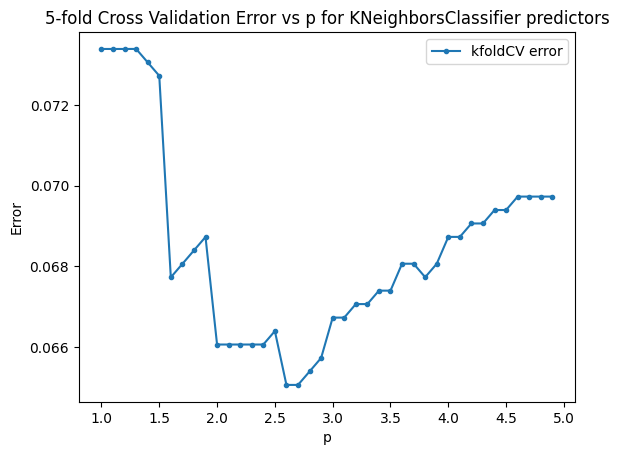

In [15]:
# Classifying the real-world dataset

Xr, yr = utils.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))
spamdata = TrainAndTestData(*utils.create_split(Xr, yr, 0.7))
Vectorizer = utils.SMS_Vectorizer(spamdata.X_train, d=300)
vectorized_data = TrainAndTestData(Vectorizer.vectorize(spamdata.X_train), spamdata.y_train, Vectorizer.vectorize(spamdata.X_test), spamdata.y_test)

kfolds = 5

#### TASK 6 CODE
# Hyperparameter: p, of KNearestNeighbors
ps = np.arange(1, 5, 0.1)
val_errs = []
for p in ps:
    val_errs.append(kfoldCV_err(vectorized_data.X_train, vectorized_data.y_train, kfolds, KNeighborsClassifier, p = p))

plt.figure()
plt.plot(ps, val_errs, label=f'kfoldCV error', marker='.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Error')
plt.title(f'{kfolds}-fold Cross Validation Error vs p for KNeighborsClassifier predictors')

best_p = ps[np.argmin(val_errs)]
val_err_best_p = np.min(val_errs)

print(f'p: {best_p} is best, val_err: {val_err_best_p*100:0.2f}%')
#### TASK 6 CODE

### [Task 7 ] Modify `DecisionTreeScratch`

In this task, you will modify the decision tree implementation in some non-trivial way you want and attain lower training error than `scikit-learn`'s implementation. You need to make at least 1 modification, among the choices in the list or any of the hyperparameters `scikit-learn` implements.
- Pruning, with any strategy (not necessarily Minimal Cost-Complexity Pruning)
- Intervals instead of thresholds for predicates in internal nodes
- Feature importances, where the tree prioritizes splitting on certain features based on a specified $d$-dimensional array of importance weights

Show that your modifications get lower cross-validation error on spiral data and spam data by comparing trees of 2 different depths (e.g. instantiate trees of depth 5 and 10 and compare the corresponding cross-validation errors).

Also write a few sentences on what you implemented so the graders know.

**DO NOT remove `max_depth` from your implementation.**

In [16]:

# Paste here your code for DecisionTreeScratch from HW2
class Node:
    def __init__(self, left_subtree, right_subtree, label: Optional[int],
                 split_feature: Optional[int], split_thres: Optional[float],
                 gini: float, n_samples_per_label: List[int], split_lb : Optional[float] = -np.inf, split_ub : Optional[float]= np.inf):
        '''
        To denote a leaf node, set left_subtree, right_subtree, split_feature, split_thres to None.
        To denote an internal node, set label to None and others to non-None.

        Args:
            left_subtree: Node object for the left subtree (or None)
            right_subtree: Node object for the right subtree (or None)
            label: predicted label at this node, in case of a Leaf node
            split_feature: feature this node splits data at, in case of an internal node
            split_thres: threshold this node splits data at, in case of an internal node
            gini: gini index at the current node using all labels available at the current node
            n_samples_per_label: list of #samples at the current node per each label
                (using labels from the training set), ordered in increasing order of label
        '''
        self.left_subtree = left_subtree
        self.right_subtree = right_subtree
        self.label = label
        self.split_feature = split_feature
        self.split_thres = split_thres
        self.gini = gini
        self.n_samples_per_label = n_samples_per_label
        self.split_lb = split_lb
        self.split_ub = split_ub

    @staticmethod
    def print_tree(node, depth: int = 0):
        common_label_space = f'|-{"--"*depth}'
        common_label_info = f'gini: {node.gini:0.3f} | #samples: {node.n_samples_per_label}'
        if node.left_subtree is None:
            # Leaf node
            print(f'{common_label_space}[ Label {node.label} | {common_label_info} ]')
        else:
            # Internal node
            print(f'{common_label_space}[ Split X[{node.split_feature+1}] at {node.split_thres:0.3f} | {common_label_info} ]')
            Node.print_tree(node.left_subtree, depth+1)
            Node.print_tree(node.right_subtree, depth+1)


class DecisionTreeScratch:
    '''
    DecisionTree of variable max depth. Splits are made using gini index and all possible splits are considered
    at each node while training.
    '''

    def __init__(self, max_depth: Optional[int]):
        '''
        Args:
            max_depth: depth (integer or None); None specifies to construct a tree with unrestricted depth
        '''
        assert (max_depth is None) or (max_depth > 0)
        self.max_depth = max_depth
        self.tree = None
        self.train_labels = None # sorted numpy array of labels in the training set (just the unique labels)

    def calculate_gini_index(self, y: np.ndarray) -> float:
        '''Returns the gini index of labels y.'''
        gini = 0.

        n = len(y)
        for l in self.train_labels:
            pl = sum((y == l).astype(int)) / n
            gini += pl*(1-pl)

        return gini

    def find_split_thres(self, X: np.ndarray, y: np.ndarray, feature: int) -> Tuple[float, float]:
        '''
        Returns (split_thres, norm_gini_at_split_thres) s.t. data points (X, y)
        when split at coordinate `feature` at threshold `split_thres` has
        minimum (normalized) gini index value `norm_gini_at_split_thres` among all possible thresholds.

        Args:
            X: data features
            y: data labels
            feature: feature to split at (0 <= feature < #features in X)

        Returns:
            (split_thres, norm_gini_at_split_thres)
        '''
        split_thres, norm_gini_at_split_thres = np.inf, np.inf

        sort_idxs_split = np.argsort(X[:, feature])
        X_sorted, y_sorted = X[sort_idxs_split], y[sort_idxs_split]
        n = len(X)

        all_thres = X_sorted[:-1, feature] + ((X_sorted[1:, feature] - X_sorted[:-1, feature]) / 2)
        for thres in all_thres:
            idxs_for_left = X_sorted[:, feature] <= thres
            idxs_for_right = X_sorted[:, feature] > thres
            n_left, n_right = sum(idxs_for_left.astype(int)), sum(idxs_for_right.astype(int))
            gini_left = self.calculate_gini_index(y_sorted[idxs_for_left])
            gini_right = self.calculate_gini_index(y_sorted[idxs_for_right])
            norm_gini = (n_left/n * gini_left) + (n_right/n * gini_right)

            if norm_gini < norm_gini_at_split_thres:
                split_thres = thres
                norm_gini_at_split_thres = norm_gini

        return split_thres, norm_gini_at_split_thres

    def fit_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Node:
        '''
        Trains a decision tree of specified depth on training data (X, y).

        Args:
            X: data features
            y: data labels
            depth: depth of tree to train

        Returns:
            node: root node of the tree
        '''
        assert len(y) > 0
        gini = self.calculate_gini_index(y)
        n_samples_per_label = [sum(y == l) for l in self.train_labels]

        if depth == 0:
            # Leaf node. Predict the majority of y
            label = stats.mode(y, axis=None)[0]
            return Node(None, None, label, None, None, gini, n_samples_per_label)

        if all(y == y[0]):
            # If y has same labels, no need to split further
            return Node(None, None, y[0], None, None, gini, n_samples_per_label)

        # y has different labels, create internal node
        # The best split is the coordinate with the minimum gini index
        split_feature = -1
        split_thres = np.inf
        best_gini_on_split = np.inf

        # BUG AND CORRECTION IS HERE.
        n_features = X.shape[1]
        for i in range(n_features):
            # Find best split value for coord i
            split_i_thres, gini_split_on_i = self.find_split_thres(X, y, i)
            if gini_split_on_i < best_gini_on_split:
                # Update the best coord
                split_feature = i
                split_thres = split_i_thres
                best_gini_on_split = gini_split_on_i

        # Split X, y and create left and right trees using recursive calls
        idxs_for_left = X[:, split_feature] <= split_thres
        idxs_for_right = X[:, split_feature] > split_thres
        subtree_depth = depth if depth is None else depth-1
        left_tree = self.fit_tree(X[idxs_for_left], y[idxs_for_left], subtree_depth)
        right_tree = self.fit_tree(X[idxs_for_right], y[idxs_for_right], subtree_depth)

        # Create an internal node with left and right trees and return
        return Node(left_tree, right_tree, None, split_feature, split_thres, gini, n_samples_per_label)

    def fit(self, X: np.ndarray, y: np.ndarray):
        '''
        Trains a decision tree of depth max_depth on training data (X, y).

        Args:
            X: data features
            y: data labels
        '''
        self.train_labels = np.sort(np.unique(y))
        self.tree = self.fit_tree(X, y, self.max_depth)

    def predict_with_tree(self, root_node: Node, x: np.ndarray) -> int:
        '''Predicts the label for a single data point x using the tree rooted at root_node.'''
        assert len(x.shape) == 1
        y = 0

        #### TASK 7 CODE
        if root_node.label is not None:
            return root_node.label
        
        if x[root_node.split_feature] > root_node.split_thres:
            y = self.predict_with_tree(root_node.right_subtree,x)
        else:
            y = self.predict_with_tree(root_node.left_subtree, x)
        
        return y
        #### TASK 7 CODE

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Predicts the labels for data X using the trained tree

        Args:
            X: data features

        Returns:
            y: labels, same number as the data points
        '''
        assert self.tree is not None, 'Decision tree not trained!'

        y = np.zeros(len(X), dtype=int)
        for i in range(X.shape[0]):
            y[i] = self.predict_with_tree(self.tree, X[i])
        return y

class DecisionTreeModified(DecisionTreeScratch):
    '''
    DecisionTree of variable max depth. Splits are made using gini index and all possible splits are considered
    at each node while training.
    '''

    def __init__(self, max_depth: Optional[int]):
        '''
        Args:
            max_depth: depth (integer or None); None specifies to construct a tree with unrestricted depth
        '''
        super().__init__(max_depth=max_depth)
        # Add attributes if needed; you have access to all the inherited attributes

    # Redefine functions of DecisionTreeScratch as needed
    #### TASK 7 CODE
    # find interval instead of threshold for predicates
    # keep track of the lower, upper bound
    def find_split_interval(self, X: np.ndarray, y: np.ndarray, feature: int) -> Tuple[float, float, float]:
        """
            Output: lower_bound, upper_bound, gini_on_split
        """
        split_lb, split_ub, norm_gini_at_split_interval = -np.inf, np.inf, np.inf

        sort_idxs_split = np.argsort(X[:, feature])
        X_sorted, y_sorted = X[sort_idxs_split], y[sort_idxs_split]
        n = len(X)
        sqrtn = (2 if n > 500 else 1)
        all_thres = X_sorted[:-1, feature] + ((X_sorted[1:, feature] - X_sorted[:-1, feature]) / 2)
        idx_chosen_thres = np.arange(len(all_thres)) % sqrtn == 0
        all_thres = all_thres[idx_chosen_thres]
        all_thres = np.insert(all_thres, 0, -np.inf)
        all_thres = np.append(all_thres, np.inf)

        # generate all possible lower, upper bound from the thresholds
        # by iterating through every pair of possible thresholds
        for i in range(len(all_thres)):
            for j in range(i+1, len(all_thres)):
                lb = all_thres[i]
                ub = all_thres[j]
                # if in interval, assign to left subtree
                idxs_for_left = np.logical_and(X_sorted[:, feature] >= lb, X_sorted[:, feature] <= ub)
                idxs_for_right = np.logical_or(X_sorted[:, feature] < lb, X_sorted[:, feature] > ub)
                n_left, n_right = sum(idxs_for_left.astype(int)), sum(idxs_for_right.astype(int))
                if n_left == 0 or n_right == 0:
                    continue
                gini_left = self.calculate_gini_index(y_sorted[idxs_for_left])
                gini_right = self.calculate_gini_index(y_sorted[idxs_for_right])
                norm_gini = (n_left/n * gini_left) + (n_right/n * gini_right)
                
                if norm_gini < norm_gini_at_split_interval:
                    split_lb = lb
                    split_ub = ub
                    norm_gini_at_split_interval = norm_gini
        
        return split_lb, split_ub, norm_gini_at_split_interval

    def fit_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Node:
        '''
        Trains a decision tree of specified depth on training data (X, y).

        Args:
            X: data features
            y: data labels
            depth: depth of tree to train

        Returns:
            node: root node of the tree
        '''
        assert len(y) > 0
        gini = self.calculate_gini_index(y)
        n_samples_per_label = [sum(y == l) for l in self.train_labels]

        if depth == 0:
            # Leaf node. Predict the majority of y
            label = stats.mode(y, axis=None)[0]
            return Node(None, None, label, None, None, gini, n_samples_per_label)

        if all(y == y[0]):
            # If y has same labels, no need to split further
            return Node(None, None, y[0], None, None, gini, n_samples_per_label)

        # y has different labels, create internal node
        # The best split is the coordinate with the minimum gini index
        split_feature = -1
        best_split_lb = -np.inf
        best_split_ub = np.inf
        best_gini_on_split = np.inf

        n_features = X.shape[1]
        for i in range(n_features):
            # Find best split interval for coord i
            split_lb, split_ub, gini_split_on_i = self.find_split_interval(X, y, i)
            if gini_split_on_i < best_gini_on_split:
                # Update the best coord
                split_feature = i
                best_split_lb = split_lb
                best_split_ub = split_ub
                best_gini_on_split = gini_split_on_i
        
        # Split X, y and create left and right trees using recursive calls
        idxs_for_left = np.logical_and(X[:, split_feature] >= best_split_lb, X[:, split_feature] <= best_split_ub)
        idxs_for_right = np.logical_or(X[:, split_feature] < best_split_lb, X[:, split_feature] > best_split_ub)
        subtree_depth = depth if depth is None else depth-1
        left_tree = self.fit_tree(X[idxs_for_left], y[idxs_for_left], subtree_depth)
        right_tree = self.fit_tree(X[idxs_for_right], y[idxs_for_right], subtree_depth)

        # Create an internal node with left and right trees and return
        return Node(left_tree, right_tree, None, split_feature, None, gini, n_samples_per_label, split_lb=best_split_lb, split_ub=best_split_ub)
    
    def predict_with_tree(self, root_node: Node, x: np.ndarray) -> int:
        '''Predicts the label for a single data point x using the tree rooted at root_node.'''
        assert len(x.shape) == 1
        y = 0

        #### TASK 7 CODE
        if root_node.label is not None:
            return root_node.label
        
        if x[root_node.split_feature] >= root_node.split_lb and x[root_node.split_feature] <= root_node.split_ub:
            y = self.predict_with_tree(root_node.left_subtree,x)
        else:
            y = self.predict_with_tree(root_node.right_subtree, x)
        
        return y
    #### TASK 7 CODE

In [17]:
for data, dataname in [(spirals, "spiral")]:
    for depth in [5, 10]:
        kfolds = 5

        err_sklearn = kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, DecisionTreeClassifier, max_depth=depth)
        err_modified = kfoldCV_err(spirals.X_train, spirals.y_train, kfolds, DecisionTreeModified, max_depth=depth)

        print(f'depth: {depth}')
        print(f'Sklearn decision tree {kfolds}-fold CV error: {err_sklearn*100:0.2f}%')
        print(f'Modified decision tree {kfolds}-fold CV error: {err_modified*100:0.2f}%')
    print()

/var/folders/48/k67vwzh91m730gsww79dstgc0000gn/T/ipykernel_6320/4072097216.py:274: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(y, axis=None)[0]


depth: 5
Sklearn decision tree 5-fold CV error: 19.25%
Modified decision tree 5-fold CV error: 20.50%


/var/folders/48/k67vwzh91m730gsww79dstgc0000gn/T/ipykernel_6320/4072097216.py:274: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(y, axis=None)[0]


depth: 10
Sklearn decision tree 5-fold CV error: 17.38%
Modified decision tree 5-fold CV error: 20.25%



**Student's Note:** I didn't really manage to lower the CV error to below the sklearn decision tree after trying to vary all sorts of selecting more/less intervals. I've also include -np.inf and np.inf as possible interval bounds to also include thresholds at the predicates. I'd love to receive some feedback/explanation on why this happened. Thanks!

### [Task 8] See how good your predictor is on our Kaggle leaderboard!

Let's have some fun by competing with the class in a Kaggle competition!

In addition to the Spam prediction data we provided, there's an additional held-out testing data split that we haven't released yet. This simulates a real-world scenario where you don't know about your testing data before actually testing your machine learning models. On our [Kaggle competition webpage](https://www.kaggle.com/t/30f168c7b985486e89e826dff223d900), you can access the testing data (without ground-truth labels, of course) and use the model you are most confident in to make predictions. After submitting your predictions, you'll see a score on the **public** leaderboard, representing the empirical error evaluated on a combination of the training and validation data (i.e., the data we provided to you earlier). However, the **private** leaderboard, containing scores for the held-out testing data, is what truly matters. The results of the private leaderboard will be visible at 0:00 AM Jan. 24, after the competition concludes. Then ground-truth labels of testing data will be released afterwards.

Best of luck to you, and most importantly, have fun!

In [18]:
!wget  -O $PWD/data/SMSSpamCollection_test_text https://www.dropbox.com/scl/fi/cbwbxj862paf0bhbpmy9c/SMSSpamCollection_test_text?rlkey=7t7qrd2rawn8i7d8i1r54oum1&dl=1

In [ ]:
Xr, yr = utils.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection'))
spamdata = TrainAndTestData(*utils.create_split(Vectorizer.vectorize(Xr), yr, 0.7))

print(spamdata.X_train.shape)
# spam_dt_clf = KNeighborsClassifier(n_neighbors=5)
# spam_dt_clf.fit(spamdata.X_train, spamdata.y_train)


# vectorized_public_X = Vectorizer.vectorize(spamdata.X_test)
# public_y = spamdata.y_test
# private_X, private_y = utils.read_sms_spam_data(os.path.join(os.getcwd(), 'data/SMSSpamCollection_test_text'))
# vectorized_private_X = Vectorizer.vectorize(private_X)
# X = np.concatenate([vectorized_public_X, vectorized_private_X])
# pred_y = spam_dt_clf.predict(X)

In [ ]:
with open('prediction.csv', 'w') as f:
    f.write('ID,LABEL\n')
    for i, y in enumerate(pred_y):
        f.write(f"{i},{str(y)}\n")